In [1]:
import numpy as np
import pandas as pd
import pybedtools
from pybedtools import BedTool
import gzip
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def load_matrices_per_tissue(tissue, annotation):
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
    pos_names = [f'bin_{str(i+1)}' for i in range(30)]

    if 'snmf' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.snmf.flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.snmf.flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices/{tissue}.{annotation}.retained_introns.mat.gz'
    elif 'gencode' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.gencode.flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.gencode.flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices/{tissue}.{annotation}.retained_introns.mat.gz'
    elif 'appris' in annotation:
        fk1_file = f'../code/CoveragePlots/matrices/{tissue}.appris_flanking_exons_1.mat.gz'
        fk2_file = f'../code/CoveragePlots/matrices/{tissue}.appris_flanking_exons_2.mat.gz'
        intron_file = f'../code/CoveragePlots/matrices/{tissue}.appris_introns.mat.gz'

    fk1 = pd.read_csv(fk1_file, sep='\t', skiprows=1, names=col_names + pos_names, index_col=3)

    fk2 = pd.read_csv(fk2_file, sep='\t', skiprows=1, names=col_names + pos_names, index_col=3)
    
    intron = pd.read_csv(intron_file, sep='\t', skiprows=1, names=col_names + pos_names_intron, index_col=3)

    return fk1, intron, fk2

In [3]:
def get_metaplot_input(tissue, annotation):
    fk1, intron, fk2 = load_matrices_per_tissue(tissue, annotation)
    
    col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
    pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
    pos_names = [f'bin_{str(i+1)}' for i in range(30)]
    
    
    pos_introns = intron.loc[intron.strand == '+'].index
    neg_introns = intron.loc[intron.strand == '-'].index
    
    norm_factor_pos = pd.concat([fk1.loc[pos_introns, pos_names[5:25]], fk2.loc[pos_introns, pos_names[5:25]]], axis=1).mean(axis=1)
    norm_factor_neg = pd.concat([fk1.loc[neg_introns, pos_names[5:25]], fk2.loc[neg_introns, pos_names[5:25]]], axis=1).mean(axis=1)
    
    fk1_meta = fk1.loc[norm_factor_pos.index, pos_names[:25]]
    intron_meta = intron.loc[norm_factor_pos.index, pos_names_intron[6:-5]]
    fk2_meta = fk2.loc[norm_factor_pos.index, pos_names[5:]]
    meta_X_pos = pd.concat([fk1_meta, intron_meta, fk2_meta], axis=1)
    meta_X_pos.columns = [f'bin_{str(i+1)}' for i in range(meta_X_pos.shape[1])]
    idx = norm_factor_pos.loc[norm_factor_pos >= 0.01].index
    norm_X_pos = meta_X_pos.loc[idx].divide(norm_factor_pos.loc[idx], axis=0)
    
    
    fk1_meta = fk2.loc[norm_factor_neg.index, pos_names[:25]]
    intron_meta = intron.loc[norm_factor_neg.index, pos_names_intron[6:-5]]
    fk2_meta = fk1.loc[norm_factor_neg.index, pos_names[5:]]
    meta_X_neg = pd.concat([fk1_meta, intron_meta, fk2_meta], axis=1)
    meta_X_neg.columns = [f'bin_{str(i+1)}' for i in range(meta_X_pos.shape[1])]
    idx = norm_factor_neg.loc[norm_factor_neg >= 0.01].index
    norm_X_neg = meta_X_neg.loc[idx].divide(norm_factor_neg.loc[idx], axis=0)
    
    norm_X = pd.concat([norm_X_pos, norm_X_neg], axis=0)

    return norm_X

In [4]:
norm_X_snmf_gencode = get_metaplot_input('Liver', 'snmf_and_gencode')
norm_X_snmf = get_metaplot_input('Liver', 'snmf_only')
norm_X_snmf_all = get_metaplot_input('Liver', 'snmf')
norm_X_gencode = get_metaplot_input('Liver', 'gencode_only')
norm_X_appris = get_metaplot_input('Liver', 'appris_introns')

In [5]:
len(norm_X_snmf_gencode.index.intersection(norm_X_snmf_all.index)) == len(norm_X_snmf_gencode.index)

True

In [6]:
norm_X_snmf_overlap = norm_X_snmf_all.loc[norm_X_snmf_all.index.difference(norm_X_snmf_gencode.index).difference(norm_X_snmf.index)]

In [7]:
def plot_intron_metaplot(norm_X, axes=None):
    if axes is None:
        fig, axes = plt.subplots(ncols = 5, figsize=(20, 3))


    avg_coverage = norm_X[norm_X.columns[25:-25]].mean(axis=1)
    Q5 = avg_coverage.loc[avg_coverage >= avg_coverage.quantile(0.8)].index
    Q4 = avg_coverage.loc[
        (avg_coverage <= avg_coverage.quantile(0.8)) & (avg_coverage >= avg_coverage.quantile(0.6))
    ].index
    Q3 = avg_coverage.loc[
        (avg_coverage <= avg_coverage.quantile(0.6)) & (avg_coverage >= avg_coverage.quantile(0.4))
    ].index
    Q2 = avg_coverage.loc[
        (avg_coverage <= avg_coverage.quantile(0.4)) & (avg_coverage >= avg_coverage.quantile(0.2))
    ].index
    Q1 = avg_coverage.loc[avg_coverage <= avg_coverage.quantile(0.2)].index

    axes[0].fill_between(np.arange(20), [0]*20, np.array(norm_X.loc[Q1].median(axis=0))[5:25], color='black', zorder = 2)
    axes[0].fill_between(np.arange(98)+19, [0]*98, np.array(norm_X.loc[Q1].median(axis=0))[25:-26], color='gray', zorder = 1)
    axes[0].fill_between(np.arange(21)+116,[0]*21, np.array(norm_X.loc[Q1].median(axis=0))[-26:-5], color='black', zorder = 2)
    axes[0].set_xlim([-5, 142])

    axes[1].fill_between(np.arange(20), [0]*20, np.array(norm_X.loc[Q2].median(axis=0))[5:25], color='black', zorder = 2)
    axes[1].fill_between(np.arange(98)+19, [0]*98, np.array(norm_X.loc[Q2].median(axis=0))[25:-26], color='gray', zorder = 1)
    axes[1].fill_between(np.arange(21)+116,[0]*21, np.array(norm_X.loc[Q2].median(axis=0))[-26:-5], color='black', zorder = 2)
    axes[1].set_xlim([-5, 142])
    
    axes[2].fill_between(np.arange(20), [0]*20, np.array(norm_X.loc[Q3].median(axis=0))[5:25], color='black', zorder = 2)
    axes[2].fill_between(np.arange(98)+19, [0]*98, np.array(norm_X.loc[Q3].median(axis=0))[25:-26], color='gray', zorder = 1)
    axes[2].fill_between(np.arange(21)+116,[0]*21, np.array(norm_X.loc[Q3].median(axis=0))[-26:-5], color='black', zorder = 2)
    axes[2].set_xlim([-5, 142])
    
    axes[3].fill_between(np.arange(20), [0]*20, np.array(norm_X.loc[Q4].median(axis=0))[5:25], color='black', zorder = 2)
    axes[3].fill_between(np.arange(98)+19, [0]*98, np.array(norm_X.loc[Q4].median(axis=0))[25:-26], color='gray', zorder = 1)
    axes[3].fill_between(np.arange(21)+116,[0]*21, np.array(norm_X.loc[Q4].median(axis=0))[-26:-5], color='black', zorder = 2)
    axes[3].set_xlim([-5, 142])
    
    axes[4].fill_between(np.arange(20), [0]*20, np.array(norm_X.loc[Q5].median(axis=0))[5:25], color='black', zorder = 2)
    axes[4].fill_between(np.arange(98)+19, [0]*98, np.array(norm_X.loc[Q5].median(axis=0))[25:-26], color='gray', zorder = 1)
    axes[4].fill_between(np.arange(21)+116,[0]*21, np.array(norm_X.loc[Q5].median(axis=0))[-26:-5], color='black', zorder = 2)
    axes[4].set_xlim([-5, 142])

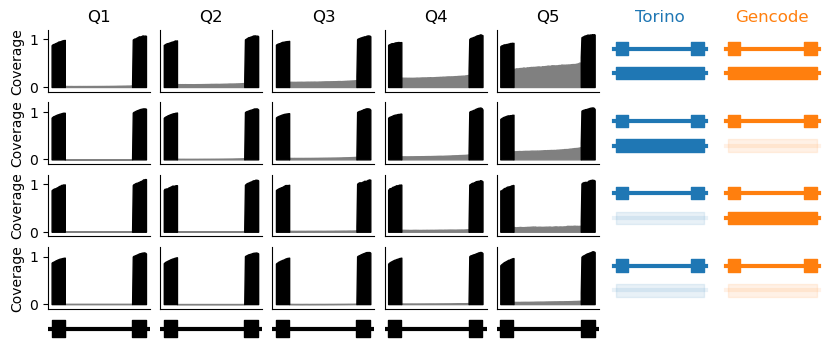

In [54]:
fig, axes = plt.subplots(nrows = 5, ncols = 7, figsize=(10, 4), gridspec_kw={'wspace':0.1, 'height_ratios': [1, 1, 1, 1, 0.3]})
plot_intron_metaplot(norm_X_snmf_gencode, axes[0,:])
plot_intron_metaplot(norm_X_snmf, axes[1,:])
plot_intron_metaplot(norm_X_gencode, axes[2,:])
plot_intron_metaplot(norm_X_appris, axes[3,:])

for i in range(5):
    axes[4, i].plot([-3, 139], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
    axes[4, i].fill_between(np.arange(20), [0]*20, [1]*20, color='black', zorder=2)
    axes[4, i].fill_between(np.arange(21)+116, [0]*21, [1]*21, color='black', zorder=2)
    axes[4, i].set_xlim([-5, 142])
    # axes[4, i].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='black', zorder=2)
    axes[4, i].set_xticks([])
    axes[4, i].set_yticks([])
    axes[4, i].spines['top'].set_visible(False)
    axes[4, i].spines['right'].set_visible(False)
    axes[4, i].spines['bottom'].set_visible(False)
    axes[4, i].spines['left'].set_visible(False)
    
    for j in range(4):
        if i > 0:
            axes[j, i].set_yticks([])
    
        axes[j, i].set_ylim([-0.1, 1.2])
        axes[j, i].set_xticks([])
        axes[j, i].spines['top'].set_visible(False)
        axes[j, i].spines['right'].set_visible(False)

axes[0, 0].set_ylabel('Coverage')
axes[1, 0].set_ylabel('Coverage')
axes[2, 0].set_ylabel('Coverage')
axes[3, 0].set_ylabel('Coverage')

axes[0, 0].set_title('Q1')
axes[0, 1].set_title('Q2')
axes[0, 2].set_title('Q3')
axes[0, 3].set_title('Q4')
axes[0, 4].set_title('Q5')

for j in range(4):
    axes[j, 5].set_ylim([-1, 4])
    axes[j, 6].set_ylim([-1, 4])
    
    axes[j, 5].plot([-3, 139], [2.5, 2.5], c='tab:blue', zorder=1, linewidth = 3)
    axes[j, 5].fill_between(np.arange(20), [2]*20, [3]*20, color='tab:blue', zorder=2)
    axes[j, 5].fill_between(np.arange(21)+116, [2]*21, [3]*21, color='tab:blue', zorder=2)

    axes[j, 6].plot([-3, 139], [2.5, 2.5], c='tab:orange', zorder=1, linewidth = 3)
    axes[j, 6].fill_between(np.arange(20), [2]*20, [3]*20, color='tab:orange', zorder=2)
    axes[j, 6].fill_between(np.arange(21)+116, [2]*21, [3]*21, color='tab:orange', zorder=2)
    
    if j in [0, 1]:
        a = 1
    else:
        a = 0.1
    

    axes[j, 5].plot([-3, 139], [0.5, 0.5], c='tab:blue', zorder=1, alpha=a, linewidth = 3)
    axes[j, 5].fill_between(np.arange(137), [0]*137, [1]*137, color='tab:blue', zorder=2, alpha=a)
    
    if j in [0, 2]:
        a = 1
    else:
        a = 0.1

    axes[j, 6].plot([-3, 139], [0.5, 0.5], c='tab:orange', zorder=1, alpha=a, linewidth = 3)
    axes[j, 6].fill_between(np.arange(137), [0]*137, [1]*137, color='tab:orange', zorder=2, alpha=a)
    

    # axes[j, 6].plot([0, 380], [0.5, 0.5], c='tab:orange', linewidth=3)
    # axes[j, 6].fill_between(np.arange(30, 90), [0]*60, [1]*60, color='tab:orange', zorder=2)
    # axes[j, 6].fill_between(np.arange(30, 90)+130, [0]*60, [1]*60, color='tab:orange', zorder=2)
    # axes[j, 6].fill_between(np.arange(30, 90)+260, [0]*60, [1]*60, color='tab:orange', zorder=2)

    # axes[j, 6].plot([0, 380], [2.5, 2.5], c='tab:orange', linewidth=3)
    # axes[j, 6].fill_between(np.arange(30, 90), [2]*60, [3]*60, color='tab:orange', zorder=2)
    # # axes[j, 6].fill_between(np.arange(30, 90)+130, [2]*60, [3]*60, color='tab:orange', zorder=2)
    # axes[j, 6].fill_between(np.arange(30, 90)+260, [2]*60, [3]*60, color='tab:orange', zorder=2)

for j in range(5):
    for i in range(5, 7):
        axes[j, i].set_xticks([])
        axes[j, i].set_yticks([])
        axes[j, i].spines['top'].set_visible(False)
        axes[j, i].spines['right'].set_visible(False)
        axes[j, i].spines['bottom'].set_visible(False)
        axes[j, i].spines['left'].set_visible(False)

axes[0, 5].set_title('Torino', c='tab:blue')
axes[0, 6].set_title('Gencode', c='tab:orange')

plt.savefig('../code/scratch_figures/figure2/intron_metaplot_quintiles.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_metaplot_quintiles.png', bbox_inches='tight', dpi=500)

In [83]:
norm_X_snmf.loc[norm_X_snmf.max(axis=1) <= 10]

,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,bin_10,...,bin_140,bin_141,bin_142,bin_143,bin_144,bin_145,bin_146,bin_147,bin_148,bin_149
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000187634_snmf_intron_2,0.165577,0.190243,0.077510,0.119778,0.250132,0.704614,0.697569,0.695803,0.577791,0.546081,...,0.587190,0.641984,0.923826,0.884685,0.715190,0.088086,0.133885,0.116265,0.137399,0.119778
ENSG00000187634_snmf_intron_3,0.951212,1.127739,1.073803,1.063973,1.274827,2.424325,2.228215,2.053864,1.814161,1.737903,...,0.833536,0.931604,0.833536,0.882557,0.931604,0.191220,0.009804,0.024523,0.156893,0.264765
ENSG00000187634_snmf_intron_4,0.027042,0.015447,0.003872,0.038618,0.127468,0.733896,0.733896,0.753215,0.733896,0.637322,...,1.178090,1.139472,1.126586,1.416289,1.815412,0.027042,0.073384,0.061808,0.050213,0.027042
ENSG00000187634_snmf_intron_5,0.112090,0.097337,0.103235,0.120929,0.200572,0.929116,1.027424,0.997935,0.968430,1.108192,...,0.949751,1.113458,1.274209,1.260935,1.097228,0.041300,0.000000,0.017693,0.011796,0.000000
ENSG00000187634_snmf_intron_6,0.068819,0.037276,0.000000,0.097487,0.203582,0.752710,0.759866,0.802890,0.817217,0.825825,...,1.261672,1.073240,0.905288,0.925767,1.163362,0.498932,0.582093,0.693921,0.642303,0.607902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185010_snmf_intron_16,0.555187,0.585190,0.300116,0.345082,0.495179,1.650597,1.900655,1.750636,1.750636,1.800616,...,0.300116,0.300116,0.450134,0.450134,0.436504,0.030004,0.000000,0.000000,0.000000,0.000000
ENSG00000185010_snmf_intron_17,0.532684,0.675365,0.656344,0.570775,0.570775,1.379336,1.236605,1.284182,1.300024,1.236605,...,0.618302,0.697564,0.745141,0.856138,0.837117,0.865623,1.046396,1.027326,1.046396,1.141501
ENSG00000155962_snmf_intron_1,0.062557,0.062557,0.062557,0.040659,0.031270,0.907030,0.856982,0.844473,0.813203,0.849682,...,0.875760,0.880218,0.880969,0.792351,0.813203,0.081319,0.000000,0.000000,0.000000,0.000000


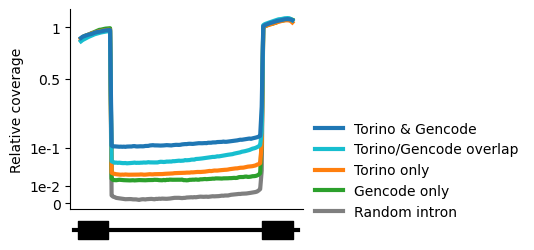

In [55]:
fig, ax = plt.subplots(nrows = 2, figsize=(3, 3), gridspec_kw={'hspace':0.1, 'height_ratios': [1, 0.1]})
ax[0].plot(np.sqrt(np.array(norm_X_snmf_gencode.median(axis=0))[5:-5]), zorder=5, linewidth=3, label='Torino & Gencode')
ax[0].plot(np.sqrt(np.array(norm_X_snmf_overlap.median(axis=0))[5:-5]), zorder=4, linewidth=3, label='Torino/Gencode overlap', c='tab:cyan')

ax[0].plot(np.sqrt(np.array(norm_X_snmf.median(axis=0))[5:-5]), zorder=3, linewidth=3, label='Torino only')
ax[0].plot(np.sqrt(np.array(norm_X_gencode.median(axis=0))[5:-5]), zorder=2, linewidth=3, label='Gencode only')
ax[0].plot(np.sqrt(np.array(norm_X_appris.median(axis=0))[5:-5]), zorder=1, c='tab:gray', linewidth=3, label='Random intron')

ax[0].set_xticks([])


ax[1].plot([-3, 139], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
ax[1].fill_between(np.arange(20), [0]*20, [1]*20, color='black', zorder=2)
ax[1].fill_between(np.arange(21)+116, [0]*21, [1]*21, color='black', zorder=2)
ax[1].set_xlim([-5, 142])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[0].set_yticks([np.sqrt(x) for x in [0, 0.01, 0.1, 0.5, 1]], ['0', '1e-2', '1e-1', '0.5', '1'])
ax[0].set_ylabel('Relative coverage')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


plt.savefig('../code/scratch_figures/figure2/intron_metaplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_metaplot.png', bbox_inches='tight', dpi=500)

(0.0, 0.2)

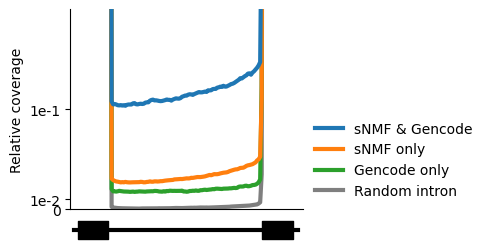

In [85]:
fig, ax = plt.subplots(nrows = 2, figsize=(3, 3), gridspec_kw={'hspace':0.1, 'height_ratios': [1, 0.1]})
ax[0].plot(np.array(np.array(norm_X_snmf_gencode.median(axis=0))[5:-5]), zorder=4, linewidth=3, label='sNMF & Gencode')
ax[0].plot(np.array(np.array(norm_X_snmf.median(axis=0))[5:-5]), zorder=3, linewidth=3, label='sNMF only')
ax[0].plot(np.array(np.array(norm_X_gencode.median(axis=0))[5:-5]), zorder=2, linewidth=3, label='Gencode only')
ax[0].plot(np.array(np.array(norm_X_appris.median(axis=0))[5:-5]), zorder=1, c='tab:gray', linewidth=3, label='Random intron')

ax[0].set_xticks([])


ax[1].plot([-3, 139], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
ax[1].fill_between(np.arange(20), [0]*20, [1]*20, color='black', zorder=2)
ax[1].fill_between(np.arange(21)+116, [0]*21, [1]*21, color='black', zorder=2)
ax[1].set_xlim([-5, 142])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[0].set_yticks([np.array(x) for x in [0, 0.01, 0.1, 0.5, 1]], ['0', '1e-2', '1e-1', '0.5', '1'])
ax[0].set_ylabel('Relative coverage')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))
ax[0].set_ylim([0, 0.2])


(0.0, 0.25)

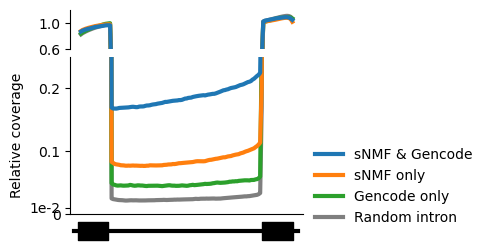

In [37]:

fig, ax = plt.subplots(nrows = 3, figsize=(3, 3), gridspec_kw={'hspace':0.1, 'height_ratios': [0.2, 0.8, 0.1]})


ax[0].plot(np.array(np.array(norm_X_snmf_gencode.loc[norm_X_snmf_gencode.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=4, linewidth=3, label='sNMF & Gencode')
ax[0].plot(np.array(np.array(norm_X_snmf.loc[norm_X_snmf.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=3, linewidth=3, label='sNMF only')
ax[0].plot(np.array(np.array(norm_X_gencode.loc[norm_X_gencode.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=2, linewidth=3, label='Gencode only')
ax[0].plot(np.array(np.array(norm_X_appris.loc[norm_X_appris.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=1, c='tab:gray', linewidth=3, label='Random intron')

ax[0].set_xticks([])
ax[0].set_yticks([0.6, 1])

ax[0].set_ylim([0.6, 1.2])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
# ax[0].spines['left'].set_visible(False)




ax[1].plot(np.array(np.array(norm_X_snmf_gencode.loc[norm_X_snmf_gencode.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=4, linewidth=3, label='sNMF & Gencode')
ax[1].plot(np.array(np.array(norm_X_snmf.loc[norm_X_snmf.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=3, linewidth=3, label='sNMF only')
ax[1].plot(np.array(np.array(norm_X_gencode.loc[norm_X_gencode.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=2, linewidth=3, label='Gencode only')
ax[1].plot(np.array(np.array(norm_X_appris.loc[norm_X_appris.max(axis=1) <= 3].mean(axis=0))[5:-5]), zorder=1, c='tab:gray', linewidth=3, label='Random intron')

ax[1].set_xticks([])


ax[2].plot([-3, 139], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
ax[2].fill_between(np.arange(20), [0]*20, [1]*20, color='black', zorder=2)
ax[2].fill_between(np.arange(21)+116, [0]*21, [1]*21, color='black', zorder=2)
ax[2].set_xlim([-5, 142])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[2].spines['left'].set_visible(False)

ax[1].set_yticks([np.array(x) for x in [0, 0.01, 0.1, 0.2, 1]], ['0', '1e-2', '0.1', '0.2', '1'])
ax[1].set_ylabel('Relative coverage')

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[1].legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))
ax[1].set_ylim([0, 0.25])


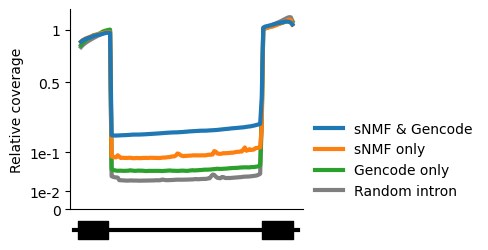

In [12]:
fig, ax = plt.subplots(nrows = 2, figsize=(3, 3), gridspec_kw={'hspace':0.1, 'height_ratios': [1, 0.1]})
ax[0].plot(np.sqrt(np.array(norm_X_snmf_gencode.mean(axis=0))[5:-5]), zorder=4, linewidth=3, label='sNMF & Gencode')
ax[0].plot(np.sqrt(np.array(norm_X_snmf.mean(axis=0))[5:-5]), zorder=3, linewidth=3, label='sNMF only')
ax[0].plot(np.sqrt(np.array(norm_X_gencode.mean(axis=0))[5:-5]), zorder=2, linewidth=3, label='Gencode only')
ax[0].plot(np.sqrt(np.array(norm_X_appris.mean(axis=0))[5:-5]), zorder=1, c='tab:gray', linewidth=3, label='Random intron')

ax[0].set_xticks([])


ax[1].plot([-3, 139], [0.5, 0.5], c='black', zorder=1, linewidth = 3)
ax[1].fill_between(np.arange(20), [0]*20, [1]*20, color='black', zorder=2)
ax[1].fill_between(np.arange(21)+116, [0]*21, [1]*21, color='black', zorder=2)
ax[1].set_xlim([-5, 142])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[0].set_yticks([np.sqrt(x) for x in [0, 0.01, 0.1, 0.5, 1]], ['0', '1e-2', '1e-1', '0.5', '1'])
ax[0].set_ylabel('Relative coverage')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[0].legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


In [9]:
def get_boxplot_input(mat_list, label_list):

    ir_column = []
    label_column = []
    for i, mat in enumerate(mat_list):
        label = label_list[i]
    
        # norm_factor = mat[exon_bins].mean(axis=1)
        # idx = norm_factor.loc[norm_factor >= 0.01].index
        
        X = mat
        xcols = X.columns[25:-25]
        y = np.minimum(X[xcols], 1)
        ir_column += list(np.sqrt(y.mean(axis=1)))
        label_column += [label]*X.shape[0]
        
    out_df = pd.DataFrame()
    out_df['ir_percent'] = ir_column
    out_df['label'] = label_column

    return out_df

In [10]:
df = get_boxplot_input([norm_X_snmf_gencode, norm_X_snmf_overlap, norm_X_snmf, norm_X_gencode, norm_X_appris], 
                  ['snmf_and_gencode', 'snmf_overlap', 'snmf_only', 'gencode_only', 'no_intron_retention'])

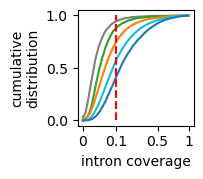

In [90]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
colores = ['tab:blue', 'tab:cyan', 'tab:orange', 'tab:green', 'tab:gray'][::-1]

for i, label in enumerate(['snmf_and_gencode', 'snmf_overlap', 'snmf_only', 'gencode_only', 'no_intron_retention'][::-1]):
    df_ = df.loc[df.label == label]
    c = colores[i]
    ax.plot(np.array(df_.ir_percent.sort_values()), np.linspace(0, 1, len(df_)), c=c, label=label)

ax.plot([np.sqrt(0.1), np.sqrt(0.1)], [0, 1], 'r--')

ax.set_xticks([0, np.sqrt(0.1),  np.sqrt(0.5), np.sqrt(1)], ['0',  '0.1','0.5', '1'], rotation=0)
ax.set_ylabel('cumulative\ndistribution')
# ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('intron coverage')


plt.savefig('../code/scratch_figures/figure2/intron_cdf.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_cdf.png', bbox_inches='tight', dpi=500)

In [91]:
snmf_introns = pd.read_csv('../code/CoveragePlots/bed_files/introns/snmf.retained_introns.bed.gz', sep='\t', 
                          names = ['chrom', 'start', 'end', 'ir_id', 'isoforms', 'strand'])
snmf_introns['gene'] = snmf_introns.ir_id.apply(lambda x: x.split('_')[0])

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pybedtools
import gzip



def extract_retained_introns(protein_coding_bed, retained_intron_bed):
    X = pybedtools.BedTool.from_dataframe(protein_coding_bed)
    Y = pybedtools.BedTool.from_dataframe(retained_intron_bed)

    intersection = Y.intersect(X, c=True).to_dataframe()
    intersection.columns = ['chrom', 'start', 'end', 'overlaps']
    Z = pybedtools.BedTool.from_dataframe(intersection.loc[intersection.overlaps >= 2])

    if len(Z) >= 1:

        Z = Z.subtract(X).to_dataframe()
        Z.start -= 1
        Z.end += 1
        Z = Z[['chrom', 'start', 'end']]
        Z = pybedtools.BedTool.from_dataframe(Z).intersect(X, c=True).to_dataframe()
        Z = Z.loc[Z.name >= 2]
    
        if len(Z) >= 1:
            Z.start += 1
            Z.end -= 1

    else:
        Z = pd.DataFrame(columns = ['chrom', 'start', 'end'])

    return Z

def get_coverage_percentage(bed, start, end, hard_start, hard_end):

    if len(bed) == 1:
        x = np.max([((merged_intron_retention.start - start)/(end - start)).iloc[0], 0])
        y = np.min([((merged_intron_retention.end - start)/(end - start)).iloc[0], 1])
        covered = np.abs(y-x)
    else:
    
        X = ((bed.end - start)/(end - start)).iloc[:-1]
        Y = ((bed.start - start)/(end - start)).iloc[1:]
    
        covered = 0
    
        if (X.iloc[0] > 0) and (X.iloc[0] < 1):
            x = X.iloc[0]
            covered += x
    
        for i in range(len(X)-1):
            x = np.min([np.max([0, X.iloc[i+1]]), 1])
            y = np.max([np.min([1, Y.iloc[i]]), 0])
            
            covered += np.abs(y-x)
    
        if (Y.iloc[-1] < 1) and (Y.iloc[-1] > 0):
            y = Y.iloc[-1]
            covered += np.abs(1-y)

    return covered

In [12]:
len(snmf_introns.gene.unique())

NameError: name 'snmf_introns' is not defined

In [ ]:
snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


annotation = pd.read_csv('/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/annotated.snmf.merged_isoforms.tab.gz', sep='\t')
annotation = annotation.loc[annotation.appris_transcript_length != 'appris_transcript_length']
annotation['appris_transcript_length'] = annotation.appris_transcript_length.astype(int)
annotation['gene_id'] = [x.split('.')[0] for x in annotation.transcript]


In [ ]:
gencode_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_bed, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])

In [ ]:
# from tqdm import tqdm 
# gene_counter = 0
# for gene, df in tqdm(snmf_exons.groupby('gene_id'), leave=True, position=0):

#     gencode_df = gencode_exons.loc[(gencode_exons.gene_id == gene) & (gencode_exons.transcript_type == 'protein_coding') & (~gencode_exons.appris.isna())]

#     annotated_isoforms = list(gencode_df.transcript_id)

#     # annotated_isoforms = list(df.loc[(df.transcript_type == 'protein_coding') & (~df.appris.isna())].transcript_id)
    

#     annot_slice = annotation.loc[annotation.gene_id == gene]
#     # annotated_isoforms = list(annot_slice.loc[
#     #                           annot_slice.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))
#     #                           ].transcript)

#     retained_introns = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: 'retained.intron' in x)].transcript)

#     bedtool = pybedtools.BedTool.from_dataframe(gencode_df.loc[gencode_df.transcript_id.isin(annotated_isoforms)])
#     merged_bedtool = bedtool.merge().to_dataframe()
#     if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
#         gene_counter += 1
#         # start = merged_bedtool.end.min()
#         # end = merged_bedtool.start.max()
#         # hard_start = df.start.min()
#         # hard_end = df.end.max()
        
#         # if (len(retained_introns) > 0):
#         #     print('success')
                        

In [ ]:
# annotation['aver'] = annotation.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))
# annotation['aver2'] = annotation.gencode_ref.apply(lambda x: x != '.')

In [65]:
# annotation.groupby('gene_id')[['aver', 'aver2']].max().max(axis=1).sum()

In [66]:
# annotation.appris_ref.apply(lambda x: ('intron.chain' in x) or ()

SyntaxError: incomplete input (3172261035.py, line 1)

In [13]:
col_names = ['chrom', 'start', 'end', 'intron_name', 'score', 'strand']
pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
intron_snmf_only = pd.read_csv(f'../code/CoveragePlots/matrices/Liver.snmf_only.retained_introns.mat.gz', sep='\t', 
                   names=col_names + pos_names_intron, skiprows=1)

intron_gencode_only = pd.read_csv(f'../code/CoveragePlots/matrices/Liver.gencode_only.retained_introns.mat.gz', sep='\t', 
                   names=col_names + pos_names_intron, skiprows=1)

intron_snmf_gencode = pd.read_csv(f'../code/CoveragePlots/matrices/Liver.snmf_and_gencode.retained_introns.mat.gz', sep='\t', 
                   names=col_names + pos_names_intron, skiprows=1)

col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names_intron = [f'bin_{str(i+1)}' for i in range(110)]
appris_introns = pd.read_csv('../code/CoveragePlots/matrices/Liver.appris_introns.mat.gz', sep='\t', skiprows=1, 
                             names = col_names + pos_names_intron)

In [14]:
appris_introns.shape

(58532, 116)

In [15]:
intron_gencode_only.shape

(1992, 116)

In [16]:
intron_snmf_only.shape

(53719, 116)

In [17]:
intron_snmf_gencode.shape[0]

6828

In [105]:
norm_X_gencode.shape

(1865, 149)

/tmp/jobs/41548387/ipykernel_11723/3321768875.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])


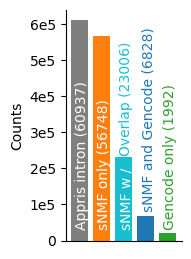

In [117]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['No intron\nretention', 'sNMF only', 'sNMF overlaps', 'sNMF and Gencode', 'Gencode only'], [60937, 56748, 23006, 6828, 1992],
       color = ['tab:gray', 'tab:orange', 'tab:cyan', 'tab:blue', 'tab:green'])
ax.set_xticks([])

ax.text(-0.2, 4000, 'Appris intron (60937)', rotation=90, c='white')

ax.text(0.8, 4000, 'sNMF only (56748)', rotation=90, c='white')
ax.text(1.8, 4000, 'sNMF w / ', rotation=90, c='white')
ax.text(1.8, 24500, 'Overlap (23006)', rotation=90, c='tab:cyan')
ax.text(2.8, 9000, 'sNMF and Gencode (6828)', rotation=90, c='tab:blue')
ax.text(3.8, 4000, 'Gencode only (1992)', rotation=90, c='tab:green')
ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Counts')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/intron_barplot_w_overlaps.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_barplot_w_overlaps.png', bbox_inches='tight', dpi=500)

/tmp/jobs/41523640/ipykernel_27639/2087447129.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])


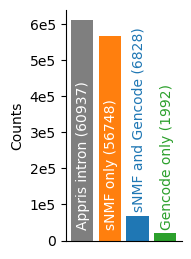

In [79]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['No intron\nretention', 'sNMF only', 'sNMF and Gencode', 'Gencode only'], [60937, 56748, 6828, 1992],
       color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green'])
ax.set_xticks([])

ax.text(-0.2, 4000, 'Appris intron (60937)', rotation=90, c='white')

ax.text(0.8, 4000, 'sNMF only (56748)', rotation=90, c='white')
ax.text(1.8, 9000, 'sNMF and Gencode (6828)', rotation=90, c='tab:blue')
ax.text(2.8, 4000, 'Gencode only (1992)', rotation=90, c='tab:green')
ax.set_yticklabels(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Counts')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/intron_barplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_barplot.png', bbox_inches='tight', dpi=500)

In [111]:
83553 - (6828 + 53719 )

23006

In [106]:
snmf_ri = pd.read_csv('../code/CoveragePlots/bed_files/introns/snmf.retained_introns.bed.gz', sep='\t',
                     names = ['chrom', 'start', 'end', 'intron_name', 'transcripts', 'strand'])
snmf_ri['gene_id'] = snmf_ri.intron_name.apply(lambda x: x.split('_')[0])

In [110]:
snmf_ri.shape

(83553, 7)

In [107]:
cassette_exons = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/cassette_exons.bed.gz', sep='\t')

annotation = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/annotated.snmf.merged_isoforms.tab.gz', sep='\t')
annotation['gene_id'] = annotation.transcript.apply(lambda x: x.split('.')[0])
second_annotation = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/second_annotation.snmf.merged_isoforms.tab.gz', sep='\t',
                               names = ['gene', 'transcript', 'chain', 'ref_transcript', 'intron_retention', 'utr'])

len(second_annotation.loc[~second_annotation.utr.isin(['no_utr', '.'])].gene.unique())

2109

In [108]:
3158 + 2759

5917

In [109]:
second_annotation.chain.value_counts()

chain
unannotated_chain    71103
annotated_chain      15877
.                       64
Name: count, dtype: int64

In [77]:
len(second_annotation.loc[second_annotation.chain == 'annotated_chain'].gene.unique())

7993

In [ ]:
snmf_introns

In [236]:
second_annotation.loc[second_annotation.chain == 'annotated_chain']

,gene,transcript,chain,ref_transcript,intron_retention,utr
6,ENSG00000188976,ENSG00000188976.isoform_1,annotated_chain,chain.match:ENST00000327044,no_intron_retention,no_utr
44,ENSG00000188157,ENSG00000188157.isoform_6,annotated_chain,subchain.a:ENST00000379370|subchain.a:ENST0000...,annotated.intron_retention,no_utr
46,ENSG00000188157,ENSG00000188157.isoform_4,annotated_chain,chain.match:ENST00000379370,no_intron_retention,no_utr
60,ENSG00000131591,ENSG00000131591.isoform_7,annotated_chain,subchain.a:ENST00000379325,no_intron_retention,no_utr
62,ENSG00000131591,ENSG00000131591.isoform_1,annotated_chain,subchain.a:ENST00000379325|subchain.a:ENST0000...,annotated.intron_retention,no_utr
...,...,...,...,...,...,...
87020,ENSG00000185973,ENSG00000185973.isoform_7,annotated_chain,subchain.a:ENST00000334398|subchain.a:ENST0000...,annotated.intron_retention,no_utr
87021,ENSG00000185973,ENSG00000185973.isoform_2,annotated_chain,chain.match:ENST00000334398,no_intron_retention,no_utr
87023,ENSG00000168939,ENSG00000168939.isoform_2,annotated_chain,chain.match:ENST00000302805,no_intron_retention,no_utr
87025,ENSG00000168939,ENSG00000168939.isoform_1,annotated_chain,chain.match:ENST00000302805,no_intron_retention,no_utr


In [217]:
second_annotation.loc[second_annotation.intron_retention != 'no_intron_retention']

,gene,transcript,chain,intron_retention,utr
0,ENSG00000187634,ENSG00000187634.isoform_1,unannotated_chain,unannotated.intron_retention,no_utr
1,ENSG00000187634,ENSG00000187634.isoform_4,unannotated_chain,unannotated.intron_retention,no_utr
2,ENSG00000187634,ENSG00000187634.isoform_3,unannotated_chain,unannotated.intron_retention,no_utr
4,ENSG00000188976,ENSG00000188976.isoform_7,unannotated_chain,unannotated.intron_retention,no_utr
9,ENSG00000188976,ENSG00000188976.isoform_6,unannotated_chain,unannotated.intron_retention,no_utr
...,...,...,...,...,...
87035,ENSG00000182484,ENSG00000182484.isoform_9,unannotated_chain,unannotated.intron_retention,no_utr
87036,ENSG00000182484,ENSG00000182484.isoform_3,unannotated_chain,unannotated.intron_retention,no_utr
87039,ENSG00000182484,ENSG00000182484.isoform_1,unannotated_chain,unannotated.intron_retention,no_utr
87041,ENSG00000182484,ENSG00000182484.isoform_8,unannotated_chain,unannotated.intron_retention,no_utr


In [ ]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['Test genes', 'Intron retention', 'Annotated transcript', 'Cassette exon', 'Alt.UTR'], [83553, 12527, 10612, 8774, 2109],
       color = ['tab:gray', 'tab:orange', 'tab:blue', 'tab:green', 'tab:purple'])
ax.set_xticks([])

ax.text(-0.2, 500, 'Test genes (15232)', rotation=90, c='white')

ax.text(0.8, 500, 'Intron retention (12472)', rotation=90, c='white')
ax.text(1.8, 500, 'Annotated transcript', rotation=90, c='white')
ax.text(1.8, 11500, '(10612)', rotation=90, c='tab:blue')
ax.text(2.8, 500, 'Cassette exon', rotation=90, c='white')
ax.text(2.8, 9500, '(8774)', rotation=90, c='tab:green')
ax.text(3.8, 500, 'Alt.', rotation=90, c='white')
ax.text(3.8, 2600, 'UTR (2109)', rotation=90, c='tab:purple')

ax.set_yticks([2500, 5000, 7500, 10000, 12500, 15000])#(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Genes')
ax.spines[['right', 'top']].set_visible(False)


# plt.savefig('../code/scratch_figures/figure2/intron_barplot.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/intron_barplot.png', bbox_inches='tight', dpi=500)

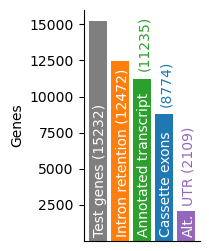

In [41]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['Test genes', 'Intron retention', 'Annotated transcript', 'Cassette exon', 'Alt.UTR'], [15232, 12472, 11235, 8774, 2109],
       color = ['tab:gray', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple'])
ax.set_xticks([])

ax.text(-0.2, 500, 'Test genes (15232)', rotation=90, c='white')

ax.text(0.8, 500, 'Intron retention (12472)', rotation=90, c='white')
ax.text(1.8, 500, 'Annotated transcript', rotation=90, c='white')
ax.text(1.8, 12000, '(11235)', rotation=90, c='tab:green')
ax.text(2.8, 500, 'Cassette exons', rotation=90, c='white')
ax.text(2.8, 9500, '(8774)', rotation=90, c='tab:blue')
ax.text(3.8, 500, 'Alt.', rotation=90, c='white')
ax.text(3.8, 2600, 'UTR (2109)', rotation=90, c='tab:purple')

ax.set_yticks([2500, 5000, 7500, 10000, 12500, 15000])#(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Genes')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot.png', bbox_inches='tight', dpi=500)

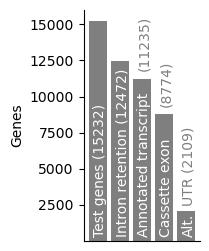

In [42]:
fig, ax = plt.subplots(figsize=(1.5, 3))

ax.bar(['Test genes', 'Intron retention', 'Annotated transcript', 'Cassette exon', 'Alt.UTR'], [15232, 12472, 11235, 8774, 2109],
       color = ['tab:gray', 'tab:gray', 'tab:gray', 'tab:gray', 'tab:gray'])
ax.set_xticks([])

ax.text(-0.2, 500, 'Test genes (15232)', rotation=90, c='white')

ax.text(0.8, 500, 'Intron retention (12472)', rotation=90, c='white')
ax.text(1.8, 500, 'Annotated transcript', rotation=90, c='white')
ax.text(1.8, 12000, '(11235)', rotation=90, c='tab:gray')
ax.text(2.8, 500, 'Cassette exon', rotation=90, c='white')
ax.text(2.8, 9500, '(8774)', rotation=90, c='tab:gray')
ax.text(3.8, 500, 'Alt.', rotation=90, c='white')
ax.text(3.8, 2600, 'UTR (2109)', rotation=90, c='tab:gray')

ax.set_yticks([2500, 5000, 7500, 10000, 12500, 15000])#(['0', '1e5', '2e5', '3e5', '4e5', '5e5', '6e5'])
ax.set_ylabel('Genes')
ax.spines[['right', 'top']].set_visible(False)


plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_gray.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/gene_annotation_barplot_gray.png', bbox_inches='tight', dpi=500)

In [37]:
pd.Index(annotation.loc[(annotation.appris_ref.apply(
    lambda x: ('intron.chain' in x) or ('ref.transcript' in x) #or ('super' in x) or ('sub' in x)
) & (annotation.gencode_ref != '.'))].gene_id.unique())

Index(['ENSG00000162493', 'ENSG00000244038', 'ENSG00000060642',
       'ENSG00000186501', 'ENSG00000092847', 'ENSG00000163879',
       'ENSG00000132128', 'ENSG00000123472', 'ENSG00000162368',
       'ENSG00000174348',
       ...
       'ENSG00000172785', 'ENSG00000107262', 'ENSG00000197859',
       'ENSG00000102226', 'ENSG00000102096', 'ENSG00000186787',
       'ENSG00000102309', 'ENSG00000102158', 'ENSG00000166707',
       'ENSG00000126903'],
      dtype='object', length=164)

In [39]:
pd.Index(annotation.loc[(annotation.appris_ref.apply(
    lambda x: ('intron.chain' in x) or ('ref.transcript' in x) or ('super' in x) or ('sub' in x)
) | (annotation.gencode_ref != '.'))].gene_id.unique()).union(pd.Index(second_annotation.loc[second_annotation.chain == 'annotated_chain'].gene.unique())).unique()

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000938', 'ENSG00000001167',
       'ENSG00000001460', 'ENSG00000001461', 'ENSG00000001497',
       'ENSG00000001561',
       ...
       'ENSG00000278619', 'ENSG00000278662', 'ENSG00000278845',
       'ENSG00000281106', 'ENSG00000283071', 'ENSG00000283199',
       'ENSG00000283378', 'ENSG00000283526', 'ENSG00000283632',
       'ENSG00000284024'],
      dtype='object', length=11235)

In [168]:
list(annotation.loc[annotation.transcript == 'ENSG00000187634.isoform_1'].gene_id)

['ENSG00000187634']

In [154]:
pd.Index(annotation.loc[(annotation.appris_ref.apply(
    lambda x: ('intron.chain' in x) or ('ref.transcript' in x) or ('super' in x)
) | (annotation.gencode_ref != '.'))].transcript())

,transcript,appris_transcript,appris_transcript_length,query_transcript_len,appris_ref,gencode_ref,gene_id
4,ENSG00000188976.isoform_1,ENST00000327044,19,19,intron.chain/utr3,.,ENSG00000188976
27,ENSG00000187583.isoform_8,ENST00000379410,16,15,utr3/retained.intron/alt.ss.3,ref.transcript:ENST00000379409,ENSG00000187583
29,ENSG00000187642.isoform_1,ENST00000433179,4,4,intron.chain/utr5/utr3,.,ENSG00000187642
34,ENSG00000188290.isoform_2,ENST00000304952,4,3,alt.5exon/retained.intron,intron.chain:ENST00000428771,ENSG00000188290
36,ENSG00000188290.isoform_4,ENST00000304952,4,2,alt.5exon/utr3/retained.intron,intron.chain:ENST00000481869,ENSG00000188290
...,...,...,...,...,...,...,...
86948,ENSG00000155962.isoform_1,ENST00000369449,6,6,ref.transcript,.,ENSG00000155962
86953,ENSG00000185973.isoform_2,ENST00000334398,8,8,ref.transcript,.,ENSG00000185973
86959,ENSG00000168939.isoform_1,ENST00000695325,3,2,transcript.subset/alt.5exon,intron.chain:ENST00000302805,ENSG00000168939
86960,ENSG00000168939.isoform_2,ENST00000695325,3,2,transcript.subset/alt.5exon,intron.chain:ENST00000302805,ENSG00000168939


In [151]:
second_annotation.chain.value_counts()

chain
unannotated_chain    71103
annotated_chain      15877
.                       64
Name: count, dtype: int64

In [163]:
pd.Index(second_annotation.loc[second_annotation.chain == 'annotated_chain'].transcript).difference(
    pd.Index(annotation.loc[(annotation.appris_ref.apply(
    lambda x: ('intron.chain' in x) or ('ref.transcript' in x) or ('super' in x) or ('sub' in x)
) | (annotation.gencode_ref != '.'))].transcript)
)

Index(['ENSG00000000003.isoform_2', 'ENSG00000000003.isoform_3',
       'ENSG00000000003.isoform_5', 'ENSG00000000005.isoform_1',
       'ENSG00000000005.isoform_2', 'ENSG00000000457.isoform_1',
       'ENSG00000000938.isoform_1', 'ENSG00000001167.isoform_5',
       'ENSG00000001561.isoform_3', 'ENSG00000001617.isoform_4',
       ...
       'ENSG00000277363.isoform_7', 'ENSG00000278299.isoform_6',
       'ENSG00000278311.isoform_4', 'ENSG00000278558.isoform_6',
       'ENSG00000278558.isoform_7', 'ENSG00000278558.isoform_8',
       'ENSG00000278662.isoform_3', 'ENSG00000278662.isoform_6',
       'ENSG00000283199.isoform_3', 'ENSG00000283199.isoform_6'],
      dtype='object', name='transcript', length=4057)

In [164]:
annotation.loc[annotation.transcript == 'ENSG00000000003.isoform_2']

,transcript,appris_transcript,appris_transcript_length,query_transcript_len,appris_ref,gencode_ref,gene_id
85708,ENSG00000000003.isoform_2,ENST00000373020,8,7,alt.5exon/utr3/retained.intron,.,ENSG00000000003


In [126]:
tested_genes = pd.read_csv('../data/protein_coding_genes.bed.gz', sep='\t')

In [134]:
len(snmf_exons.gene_id.unique())

15232

In [133]:
len(second_annotation.gene.unique())

15232

In [132]:
len(annotation.gene_id.unique())

15224

In [25]:
len(snmf_ri.gene_id.unique())

12472

In [137]:
snmf_ri

,chrom,start,end,intron_name,transcripts,strand,gene_id
0,chrX,100635746,100636608,ENSG00000000003_snmf_intron_1,ENSG00000000003.isoform_2|ENSG00000000003.isof...,-,ENSG00000000003
1,chrX,100585066,100585231,ENSG00000000005_snmf_intron_1,ENSG00000000005.isoform_1|ENSG00000000005.isof...,+,ENSG00000000005
2,chrX,100594035,100594261,ENSG00000000005_snmf_intron_2,ENSG00000000005.isoform_1|ENSG00000000005.isof...,+,ENSG00000000005
3,chrX,100599182,100599508,ENSG00000000005_snmf_intron_3,ENSG00000000005.isoform_1|ENSG00000000005.isof...,+,ENSG00000000005
4,chr20,50935236,50936148,ENSG00000000419_snmf_intron_1,ENSG00000000419.isoform_2|ENSG00000000419.isof...,-,ENSG00000000419
...,...,...,...,...,...,...,...
83548,chr9,131488096,131491425,ENSG00000288701_snmf_intron_10,ENSG00000288701.isoform_2|ENSG00000288701.isof...,+,ENSG00000288701
83549,chr9,131492260,131494405,ENSG00000288701_snmf_intron_11,ENSG00000288701.isoform_2|ENSG00000288701.isof...,+,ENSG00000288701
83550,chr9,131494486,131495740,ENSG00000288701_snmf_intron_12,ENSG00000288701.isoform_2|ENSG00000288701.isof...,+,ENSG00000288701
83551,chr6,159682638,159684854,ENSG00000291237_snmf_intron_1,ENSG00000291237.isoform_2,-,ENSG00000291237


In [27]:
cassette_exons.shape

(28464, 12)

In [28]:
len(cassette_exons.gene.unique())

8774

In [230]:
(annotation.appris_ref.apply(
    lambda x: ('intron.chain' in x) or ('ref.transcript' in x) or ('super' in x)
) | (annotation.gencode_ref != '.')).sum()

13491

In [233]:
second_annotation.chain.value_counts()

chain
unannotated_chain    71103
annotated_chain      15877
.                       64
Name: count, dtype: int64

In [232]:
second_annotation.utr.value_counts()

utr
no_utr                 81063
unannotated:alt.utr     3158
annotated:alt.utr       2759
.                         64
Name: count, dtype: int64

In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pybedtools

gencode_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/Annotations/gencode.v44.primary_assembly.exons.sorted.bed.gz'
gencode_exons = pd.read_csv(gencode_exons_bed, sep='\t', 
                            names = ['chrom', 'start', 'end', 'gene_id', 
                                                           'transcript_id', 'strand', 'exon_id', 'transcript_support_level',
                                                           'basic', 'Ensembl_canonical', 'MANE_Select', 'appris', 'transcript_type'])

snmf_exons_bed = '/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/snmf_10/tables/snmf.merged_isoforms.exons.sorted.bed.gz'
snmf_exons = pd.read_csv(snmf_exons_bed, sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 
                                                 'transcript_id', 'strand', 'factors', 'exon_id'])


annotation = pd.read_csv('../code/ebpmf_models/filtered/snmf_10/tables/annotated.snmf.merged_isoforms.tab.gz', sep='\t')
annotation = annotation.loc[annotation.appris_transcript_length != 'appris_transcript_length']
annotation['appris_transcript_length'] = annotation.appris_transcript_length.astype(int)
annotation['gene_id'] = [x.split('.')[0] for x in annotation.transcript]

In [56]:
def plot_bed_intron(bed, start, end, hard_start, hard_end, y_pos = 0, color = 'black', ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    for idx, row in bed.iterrows():
        x = np.max([((row.start - start)/(end - start)), 0])
        y = np.min([((row.end - start)/(end - start)), 1])
        ax.fill_between([x, y], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=0)

def plot_bed_lines(bed, start, end, hard_start, hard_end, y_pos = 0, color = 'black', ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    if len(bed) == 1:
        x = np.max([((bed.start - start)/(end - start)).iloc[0], 0])
        y = np.min([((bed.end - start)/(end - start)).iloc[0], 1])
        ax.fill_between([x, y], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
    else:
    
        X = ((bed.end - start)/(end - start)).iloc[:-1]
        Y = ((bed.start - start)/(end - start)).iloc[1:]
    
        if (X.iloc[0] > 0) and (X.iloc[0] < 1):
            x = X.iloc[0]
            ax.fill_between([0, x], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
            # ax.plot([0, x], [y_pos, y_pos], c=color, zorder=1)
    
        for i in range(len(X)-1):
            x = np.min([np.max([0, X.iloc[i+1]]), 1])
            y = np.max([np.min([1, Y.iloc[i]]), 0])
            
            ax.fill_between([x, y], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
    
        if (Y.iloc[-1] < 1) and (Y.iloc[-1] > 0):
            y = Y.iloc[-1]
            ax.fill_between([y, 1], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color=color, zorder=1)
            # ax.plot([y, 1], [y_pos, y_pos], c=color, zorder=1)


def extract_retained_introns(protein_coding_bed, retained_intron_bed):
    X = pybedtools.BedTool.from_dataframe(protein_coding_bed)
    Y = pybedtools.BedTool.from_dataframe(retained_intron_bed)

    intersection = Y.intersect(X, c=True).to_dataframe()
    intersection.columns = ['chrom', 'start', 'end', 'overlaps']
    Z = pybedtools.BedTool.from_dataframe(intersection.loc[intersection.overlaps >= 2])

    if len(Z) >= 1:

        Z = Z.subtract(X).to_dataframe()
        Z.start -= 1
        Z.end += 1
        Z = Z[['chrom', 'start', 'end']]
        Z = pybedtools.BedTool.from_dataframe(Z).intersect(X, c=True).to_dataframe()
        Z = Z.loc[Z.name >= 2]
    
        if len(Z) >= 1:
            Z.start += 1
            Z.end -= 1

    else:
        Z = pd.DataFrame(columns = ['chrom', 'start', 'end'])

    return Z

def get_coverage_percentage(bed, start, end, hard_start, hard_end):

    if len(bed) == 1:
        x = np.max([((merged_intron_retention.start - start)/(end - start)).iloc[0], 0])
        y = np.min([((merged_intron_retention.end - start)/(end - start)).iloc[0], 1])
        covered = np.abs(y-x)
    else:
    
        X = ((bed.end - start)/(end - start)).iloc[:-1]
        Y = ((bed.start - start)/(end - start)).iloc[1:]
    
        covered = 0
    
        if (X.iloc[0] > 0) and (X.iloc[0] < 1):
            x = X.iloc[0]
            covered += x
    
        for i in range(len(X)-1):
            x = np.min([np.max([0, X.iloc[i+1]]), 1])
            y = np.max([np.min([1, Y.iloc[i]]), 0])
            
            covered += np.abs(y-x)
    
        if (Y.iloc[-1] < 1) and (Y.iloc[-1] > 0):
            y = Y.iloc[-1]
            covered += np.abs(1-y)

    return covered

def get_intron_mean_position(bed, start, end):

    start_i = (retained_i.start - start)/(end-start)
    end_i = (retained_i.end - start)/(end-start)

    intervals = list(zip(start_i, end_i))


    # Calculate the lengths of the intervals
    lengths = [(end - start) for start, end in intervals]
    
    # Calculate the total length
    total_length = sum(lengths)
    
    # Find the point where half of the total length is reached
    half_length = total_length / 2.0
    
    # Find the cumulative lengths
    cumulative_length = 0.0
    for (start, end), length in zip(intervals, lengths):
        cumulative_length += length
        if cumulative_length >= half_length:
            # We need to move half_length - (cumulative_length - length) into the current interval
            return start + (half_length - (cumulative_length - length))
    
    # If we reach here, something went wrong (e.g., empty intervals list)
    return None



In [57]:
# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0

genes_list = []
position_list = []

for gene, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    # df = snmf_exons.loc[snmf_exons.gene_id == gene]
    annot_slice = annotation.loc[annotation.gene_id == gene]
    annotated_isoforms = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))].transcript)
    # alt_introns = list(annot_slice.loc[annot_slice.gencode_ref != '.'].transcript)
    # annotated_isoforms = annotated_isoforms + annotated_isoforms
    

    

    retained_introns = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: 'retained.intron' in x) & (annot_slice.query_transcript_len >= 1)].transcript)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        if (len(retained_introns) > 0):
            
            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) == 1:
                percent = get_coverage_percentage(merged_intron_retention, start, end, hard_start, hard_end)
            else:
                percent = 1

            if (len(merged_intron_retention) >= 1):# or ((len(merged_intron_retention) == 1) and (percent < 0.5)):

                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)

                    position_i = get_intron_mean_position(retained_i, start, end)
                    genes_list.append(gene)
                    position_list.append(position_i)
                    
                    counter += 1
                except:
                    continue
                # print(counter)
    if counter >= 500:
        break


In [58]:
df_pos = pd.DataFrame()
df_pos['gene_id'] = genes_list
df_pos['position'] = position_list

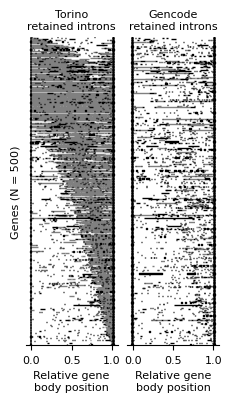

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(2.5, 4), gridspec_kw={'wspace': 0.1})

ax = axes[0]
counter = 0
y_pos = 0

for gene in df_pos.sort_values('position').gene_id: #, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = snmf_exons.loc[snmf_exons.gene_id == gene]
    annot_slice = annotation.loc[annotation.gene_id == gene]
    annotated_isoforms = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))].transcript)
    # alt_introns = list(annot_slice.loc[annot_slice.gencode_ref != '.'].transcript)
    # annotated_isoforms = annotated_isoforms + annotated_isoforms
    

    

    retained_introns = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: 'retained.intron' in x) & (annot_slice.query_transcript_len >= 1)].transcript)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        if (len(retained_introns) > 0):
            
            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) == 1:
                percent = get_coverage_percentage(merged_intron_retention, start, end, hard_start, hard_end)
            else:
                percent = 1

            if (len(merged_intron_retention) >= 1):# or ((len(merged_intron_retention) == 1) and (percent < 0.5)):

                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)

                

                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
            
                    plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)

                    # plot_bed_lines(merged_intron_retention, start, end, hard_start, hard_end, y_pos=y_pos, color = 'red', ax=ax)
            
                    # plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
                    ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    y_pos -= 1
                    counter += 1
                except:
                    continue
                # print(counter)
    if counter >= 500:
        break

ax.set_yticks([])
ax.set_ylabel('Genes (N = 500)', size=8)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('Torino\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])






ax = axes[1]


# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0



for gene in df_pos.sort_values('position').gene_id:#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = gencode_exons.loc[(gencode_exons.gene_id == gene)]
    
    annotated_isoforms = list(df.loc[(df.transcript_type == 'protein_coding') & (~df.appris.isna())].transcript_id)

    

    retained_introns = list(df.loc[df.transcript_type == 'retained_intron'].transcript_id)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        
            
            

        if (len(retained_introns) > 0):

            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) >= 2:


                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)
    
                    
    
                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
                except:
                    continue
        
                
        plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
        ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        y_pos -= 1
        counter += 1
                # print(counter)
    if counter >= 500:
        break


ax.set_yticks([])
# ax.set_ylabel('Genes (N = 500)', size=10)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('Gencode\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])


plt.savefig('../code/scratch_figures/figure2/intron_gencode_heatmap.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_gencode_heatmap.png', bbox_inches='tight', dpi=500)

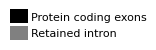

In [23]:
colores = sns.color_palette("tab10")


fig, axs = plt.subplots(2, 2, figsize=(0.5, 0.4))

colors_list = ['black', 'gray']

tissue_list_names = ['Protein coding exons', 'Retained intron']

for i, color in enumerate(colors_list):
    axs[i,0].bar([1], [1], color=color)
    axs[i,0].axis('off')  # Hide
    axs[i,0].margins(0, 0)

    axs[i,1].text(0, 0.25, tissue_list_names[i], size=8)#, c=color)
    axs[i,1].set_xticks([])
    axs[i,1].set_yticks([])
    axs[i,1].spines['right'].set_visible(False)
    axs[i,1].spines['left'].set_visible(False)
    axs[i,1].spines['top'].set_visible(False)
    axs[i,1].spines['bottom'].set_visible(False)

# axs[0].imshow(colors_list)

# plt.savefig('../code/scratch_figures/figure2/exon_intron_labels.pdf', bbox_inches='tight')
# plt.savefig('../code/scratch_figures/figure2/exon_intron_labels.png', bbox_inches='tight', dpi=500)

In [60]:
exons = pd.read_csv('/project2/yangili1/cfbuenabadn/CSQ_additional_files/EVENT_INFO-hg38.tab.gz', sep='\t')#[['GENE', 'EVENT', 'COMPLEX', 'CO_C1', 
                                                                                                            # 'CO_A', 'CO_C2', 'LE_n']]
exons = exons.dropna()
exons_cols = list(exons.columns)
exons['chrom'] = exons.CO_A.apply(lambda x: x.split(':')[0])
exons['start'] = exons.CO_A.apply(lambda x: x.split(':')[1].split('-')[0])
exons['end'] = exons.CO_A.apply(lambda x: x.split('-')[1])
exons_cols = ['chrom', 'start', 'end'] + exons_cols
exons = exons[exons_cols]

genes = pd.read_csv('../data/protein_coding_genes.bed.gz', sep='\t', names = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand'])

exons = exons.loc[exons.COMPLEX == 'IR', ['chrom', 'start', 'end', 'EVENT']].reset_index(drop=True)

exons = pybedtools.BedTool.from_dataframe(exons)
genes = pybedtools.BedTool.from_dataframe(genes)

exons = exons.intersect(genes, f=1, wao=True).to_dataframe()
exons = exons.loc[exons.blockSizes > 0, ['chrom', 'start', 'end', 'thickEnd', 'itemRgb', 'blockCount']]
exons.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand']

vastdb_introns = exons.copy()

vastdb_introns.start -= 3
vastdb_introns.end += 3

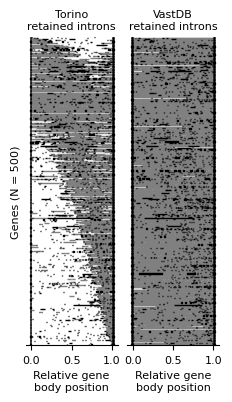

In [61]:
fig, axes = plt.subplots(ncols=2, figsize=(2.5, 4), gridspec_kw={'wspace': 0.1})

ax = axes[0]
counter = 0
y_pos = 0

for gene in df_pos.sort_values('position').gene_id: #, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = snmf_exons.loc[snmf_exons.gene_id == gene]
    annot_slice = annotation.loc[annotation.gene_id == gene]
    annotated_isoforms = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: ('intron.chain' in x) or ('ref.transcript' in x))].transcript)
    # alt_introns = list(annot_slice.loc[annot_slice.gencode_ref != '.'].transcript)
    # annotated_isoforms = annotated_isoforms + annotated_isoforms
    

    

    retained_introns = list(annot_slice.loc[annot_slice.appris_ref.apply(lambda x: 'retained.intron' in x) & (annot_slice.query_transcript_len >= 1)].transcript)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        if (len(retained_introns) > 0):
            
            merged_intron_retention = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(retained_introns)])
            merged_intron_retention = merged_intron_retention.merge().to_dataframe()

            if len(merged_intron_retention) == 1:
                percent = get_coverage_percentage(merged_intron_retention, start, end, hard_start, hard_end)
            else:
                percent = 1

            if (len(merged_intron_retention) >= 1):# or ((len(merged_intron_retention) == 1) and (percent < 0.5)):

                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)

                

                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
            
                    plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)

                    # plot_bed_lines(merged_intron_retention, start, end, hard_start, hard_end, y_pos=y_pos, color = 'red', ax=ax)
            
                    # plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
                    ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
                    y_pos -= 1
                    counter += 1
                except:
                    continue
                # print(counter)
    if counter >= 500:
        break

ax.set_yticks([])
ax.set_ylabel('Genes (N = 500)', size=8)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('Torino\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])






ax = axes[1]


# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0



# fig, ax = plt.subplots(figsize=(2, 8))
counter = 0
y_pos = 0



for gene in df_pos.sort_values('position').gene_id:#, df in snmf_exons.loc[snmf_exons.strand == '+'].groupby('gene_id'):
    df = gencode_exons.loc[(gencode_exons.gene_id == gene)]
    
    annotated_isoforms = list(df.loc[(df.transcript_type == 'protein_coding') & (~df.appris.isna())].transcript_id)

    

    retained_introns = list(vastdb_introns.loc[vastdb_introns.gene_id == gene].index)

    bedtool = pybedtools.BedTool.from_dataframe(df.loc[df.transcript_id.isin(annotated_isoforms)])
    merged_bedtool = bedtool.merge().to_dataframe()
    if (len(annotated_isoforms) > 0) and (len(merged_bedtool) >= 2):
        
    
        start = merged_bedtool.end.min()
        end = merged_bedtool.start.max()
        hard_start = df.start.min()
        hard_end = df.end.max()
        
        
            
            

        if (len(retained_introns) > 0):


            merged_intron_retention = pybedtools.BedTool.from_dataframe(vastdb_introns.loc[vastdb_introns.gene_id == gene])
            merged_intron_retention = merged_intron_retention.sort().merge().to_dataframe()

            if len(merged_intron_retention) >= 2:


                try:

                    retained_i = extract_retained_introns(merged_bedtool, merged_intron_retention)
    
                    
    
                    plot_bed_intron(retained_i, start, end, hard_start, hard_end, y_pos=y_pos, color = 'gray', ax=ax)
                except:
                    continue
        
                
        plot_bed_lines(merged_bedtool, start, end, hard_start, hard_end, y_pos=y_pos, color = 'black', ax=ax)
        ax.fill_between([-0.02, 0], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        ax.fill_between([1, 1.02], [y_pos, y_pos], [y_pos-0.1, y_pos-0.1], color='black', zorder=1)
        y_pos -= 1
        counter += 1
                # print(counter)
    if counter >= 500:
        break


ax.set_yticks([])
# ax.set_ylabel('Genes (N = 500)', size=10)
ax.set_xlabel('Relative gene\nbody position', size=8)
ax.set_title('VastDB\nretained introns', size=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([y_pos - 0.1, 0.1])
ax.tick_params(labelsize=8)
ax.set_xticks([0, 0.5, 1])


plt.savefig('../code/scratch_figures/figure2/intron_vastdb_heatmap.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_vastdb_heatmap.png', bbox_inches='tight', dpi=500)

In [27]:
def plot_mat(mat, exon_bins, pos_names, ax = None, plot_range=False, sqrt_root = True, label='', zorder = 0, c='tab:blue'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(4,4))
        
    norm_factor = mat[exon_bins].mean(axis=1)
    idx = norm_factor.loc[norm_factor >= 0.01].index

    X = mat.loc[idx, pos_names].T.divide(norm_factor.loc[idx]).T
    if sqrt_root:
        X = np.sqrt(X)

    if plot_range:
        y1 = X.quantile(0.75, axis=0)
        y0 = X.quantile(0.25, axis=0)
    
        ax.fill_between(range(len(y0)), y0, y1, linewidth=0.5, alpha=0.2, color=c, zorder=zorder)

    ax.plot(list(X.mean(axis=0)), linewidth=3, label=label, zorder=zorder, c=c)


def get_boxplot_input(mat_list, label_list, exon_bins):

    ir_column = []
    label_column = []
    for i, mat in enumerate(mat_list):
        label = label_list[i]
    
        norm_factor = mat[exon_bins].mean(axis=1)
        idx = norm_factor.loc[norm_factor >= 0.01].index
        
        X = mat.loc[idx, pos_names].T.divide(norm_factor.loc[idx]).T
        y = np.minimum(np.sqrt(X[[f'bin_{str(x)}' for x in range(7, 104)]]), 1)
        ir_column += list(y.mean(axis=1))
        label_column += [label]*X.shape[0]
        
    out_df = pd.DataFrame()
    out_df['ir_percent'] = ir_column
    out_df['label'] = label_column

    return out_df

In [38]:

col_names = ['chrom', 'start', 'end', 'gene', 'score', 'strand']
pos_names = [f'bin_{str(i+1)}' for i in range(110)]

col_names += pos_names


liver_snmf_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.gencode_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_snmf_gencode_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_and_gencode.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

liver_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.vastdb_only.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

liver_snmf_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_gencode_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.gencode_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)
liver_snmf_gencode_vastdb_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.snmf_and_gencode_and_vastdb.retained_introns.mat.gz', sep='\t', skiprows=1, names = col_names)

liver_appris_mat = pd.read_csv('../code/CoveragePlots/matrices_split/Liver.appris_introns.mat.gz', sep='\t', skiprows=1, names = col_names)



In [33]:
exon_bins = [f'bin_{str(x)}' for x in [1, 2, 3, 4, 5, 106, 107, 108, 109, 110]]
pos_names = [f'bin_{str(i+1)}' for i in range(110)]

# df = get_boxplot_input([liver_snmf_gencode_vastdb_mat, liver_snmf_gencode_mat, liver_snmf_vastdb_mat, liver_snmf_mat, 
#                         liver_gencode_vastdb_mat, liver_gencode_mat, liver_vastdb_mat, liver_appris_mat], 
#                   ['snmf_and_gencode_and_vastdb', 'snmf_and_gencode', 'snmf_and_vastdb', 'snmf_only',
#                    'gencode_and_vastdb','gencode_only', 'vastdb_only', 'no_intron_retention'], exon_bins)

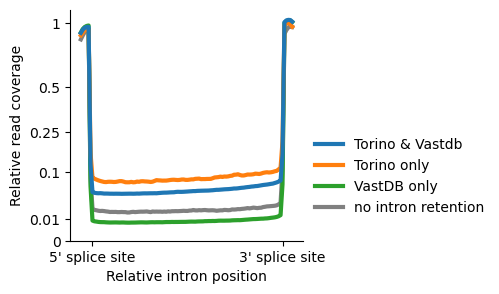

In [46]:
fig, ax = plt.subplots(figsize=(3, 3))
plot_mat(pd.concat([liver_snmf_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:blue', zorder = 4, label='Torino & Vastdb')

plot_mat(pd.concat([liver_snmf_gencode_mat, liver_snmf_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:orange', zorder = 3, label='Torino only')

plot_mat(pd.concat([liver_vastdb_mat, liver_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
         exon_bins, pos_names, ax=ax, c = 'tab:green', zorder = 2, label='VastDB only')

# plot_mat(liver_snmf_vastdb_mat, exon_bins, pos_names, ax=ax, c ='tab:brown',  zorder = 4, label='sNMF and VastDB')

# plot_mat(liver_gencode_vastdb_mat, exon_bins, pos_names, ax=ax, c = 'goldenrod', zorder = 4, label='Gencode and VastDB')
# plot_mat(liver_snmf_mat, exon_bins, pos_names, ax=ax, c='tab:orange', zorder=3, label='sNMF only')
# plot_mat(liver_gencode_mat, exon_bins, pos_names, ax=ax, c='tab:green', zorder=2, label='Gencode only')
# plot_mat(liver_vastdb_mat, exon_bins, pos_names, ax=ax, c='tab:red', zorder=2, label='VastDB only')
plot_mat(pd.concat([liver_appris_mat, liver_gencode_mat], axis=0).reset_index(drop=True), exon_bins, pos_names, ax=ax, c='gray', zorder=1, label='no intron retention')

ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([6, 104], ["5' splice site", "3' splice site"])
ax.set_xlabel('Relative intron position')


ax.set_yticks([0, np.sqrt(0.01), np.sqrt(0.1), np.sqrt(0.25), np.sqrt(0.5), np.sqrt(1)], ['0', '0.01', '0.1', '0.25', '0.5', '1'])

ax.set_ylabel('Relative read coverage')
ax.legend(frameon=False, bbox_to_anchor=(1, 0., 0.5, 0.5))


plt.savefig('../code/scratch_figures/figure2/intron_metaplots_vastdb.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_metaplots_vastdb.png', bbox_inches='tight', dpi=500)

In [50]:
df = get_boxplot_input([pd.concat([liver_snmf_vastdb_mat, liver_snmf_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        pd.concat([liver_gencode_vastdb_mat, liver_gencode_mat, liver_snmf_gencode_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        pd.concat([liver_snmf_vastdb_mat, liver_vastdb_mat, liver_gencode_vastdb_mat, liver_snmf_gencode_vastdb_mat], axis=0).reset_index(drop=True), 
                        liver_appris_mat], 
                  ['snmf_and_vastdb', 'snmf_only', 'vastdb_only', 'no_intron_retention'], exon_bins)

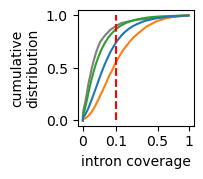

In [52]:
fig, ax = plt.subplots(figsize=(1.5,1.5))
colores = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray'][::-1]

for i, label in enumerate(['snmf_and_vastdb', 'snmf_only', 'vastdb_only', 'no_intron_retention'][::-1]):
    df_ = df.loc[df.label == label]
    c = colores[i]
    ax.plot(np.array(df_.ir_percent.sort_values()), np.linspace(0, 1, len(df_)), c=c, label=label)

ax.plot([np.sqrt(0.1), np.sqrt(0.1)], [0, 1], 'r--')

ax.set_xticks([0, np.sqrt(0.1),  np.sqrt(0.5), np.sqrt(1)], ['0',  '0.1','0.5', '1'], rotation=0)
ax.set_ylabel('cumulative\ndistribution')
# ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('intron coverage')


plt.savefig('../code/scratch_figures/figure2/intron_cdf_vastdb.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure2/intron_cdf_vastdb.png', bbox_inches='tight', dpi=500)